In [52]:
#   !pip install -q -U einops datasets matplotlib tqdm
import math
from inspect import isfunction
from functools import partial

%matplotlib inline
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
from einops import rearrange, reduce
from einops.layers.torch import Rearrange

import torch
from torch import nn, einsum
import torch.nn.functional as F

import torchvision.models as models
from skimage.util import random_noise

from PIL import Image
import requests

from torchvision.transforms import Compose, ToTensor, Lambda, ToPILImage, CenterCrop, Resize
import numpy as np
import pandas as pd

from torch.utils.data import Dataset, DataLoader

import matplotlib.pyplot as plt

In [53]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device
# use seed for reproducability
torch.manual_seed(42)

In [54]:
#   !pip install -q -U einops datasets matplotlib tqdm
import math
from inspect import isfunction
from functools import partial

import matplotlib.pyplot as plt
from tqdm.auto import tqdm
from einops import rearrange, reduce
from einops.layers.torch import Rearrange

import torch
from torch import nn, einsum
import torch.nn.functional as F

import torchvision.models as models
from skimage.util import random_noise

from PIL import Image
import requests

from torchvision.transforms import Compose, ToTensor, Lambda, ToPILImage, CenterCrop, Resize
import numpy as np

import ddpm

def exists(x):
    return x is not None

def default(val, d):
    if exists(val):
        return val
    return d() if isfunction(d) else d


def num_to_groups(num, divisor):
    groups = num // divisor
    remainder = num % divisor
    arr = [divisor] * groups
    if remainder > 0:
        arr.append(remainder)
    return arr


class Residual(nn.Module):
    def __init__(self, fn):
        super().__init__()
        self.fn = fn

    def forward(self, x, *args, **kwargs):
        return self.fn(x, *args, **kwargs) + x


def Upsample(dim, dim_out=None):
    return nn.Sequential(
        nn.Upsample(scale_factor=2, mode="nearest"),
        nn.Conv2d(dim, default(dim_out, dim), 3, padding=1),
    )


def Downsample(dim, dim_out=None):
    # No More Strided Convolutions or Pooling
    return nn.Sequential(
        Rearrange("b c (h p1) (w p2) -> b (c p1 p2) h w", p1=2, p2=2),
        nn.Conv2d(dim * 4, default(dim_out, dim), 1),
    )

class SinusoidalPositionEmbeddings(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.dim = dim

    def forward(self, time):
        device = time.device
        half_dim = self.dim // 2
        embeddings = math.log(10000) / (half_dim - 1)
        embeddings = torch.exp(torch.arange(half_dim, device=device) * -embeddings)
        embeddings = time[:, None] * embeddings[None, :]
        embeddings = torch.cat((embeddings.sin(), embeddings.cos()), dim=-1)
        return embeddings

class WeightStandardizedConv2d(nn.Conv2d):
    """
    https://arxiv.org/abs/1903.10520
    weight standardization purportedly works synergistically with group normalization
    """

    def forward(self, x):
        eps = 1e-5 if x.dtype == torch.float32 else 1e-3

        weight = self.weight
        mean = reduce(weight, "o ... -> o 1 1 1", "mean")
        var = reduce(weight, "o ... -> o 1 1 1", partial(torch.var, unbiased=False))
        normalized_weight = (weight - mean) / (var + eps).rsqrt()

        return F.conv2d(
            x,
            normalized_weight,
            self.bias,
            self.stride,
            self.padding,
            self.dilation,
            self.groups,
        )


class Block(nn.Module):
    def __init__(self, dim, dim_out, groups=8):
        super().__init__()
        self.proj = WeightStandardizedConv2d(dim, dim_out, 3, padding=1)
        self.norm = nn.GroupNorm(groups, dim_out)
        self.act = nn.SiLU()

    def forward(self, x, scale_shift=None):
        x = self.proj(x)
        x = self.norm(x)

        if exists(scale_shift):
            scale, shift = scale_shift
            x = x * (scale + 1) + shift

        x = self.act(x)
        return x


class ResnetBlock(nn.Module):
    """https://arxiv.org/abs/1512.03385"""

    def __init__(self, dim, dim_out, *, time_emb_dim=None, groups=8):
        super().__init__()
        self.mlp = (
            nn.Sequential(nn.SiLU(), nn.Linear(time_emb_dim, dim_out * 2))
            if exists(time_emb_dim)
            else None
        )

        self.block1 = Block(dim, dim_out, groups=groups)
        self.block2 = Block(dim_out, dim_out, groups=groups)
        self.res_conv = nn.Conv2d(dim, dim_out, 1) if dim != dim_out else nn.Identity()

    def forward(self, x, time_emb=None):
        scale_shift = None
        if exists(self.mlp) and exists(time_emb):
            time_emb = self.mlp(time_emb)
            time_emb = rearrange(time_emb, "b c -> b c 1 1")
            scale_shift = time_emb.chunk(2, dim=1)

        h = self.block1(x, scale_shift=scale_shift)
        h = self.block2(h)
        return h + self.res_conv(x)
    
class Attention(nn.Module):
    def __init__(self, dim, heads=4, dim_head=32):
        super().__init__()
        self.scale = dim_head**-0.5
        self.heads = heads
        hidden_dim = dim_head * heads
        self.to_qkv = nn.Conv2d(dim, hidden_dim * 3, 1, bias=False)
        self.to_out = nn.Conv2d(hidden_dim, dim, 1)

    def forward(self, x):
        b, c, h, w = x.shape
        qkv = self.to_qkv(x).chunk(3, dim=1)
        q, k, v = map(
            lambda t: rearrange(t, "b (h c) x y -> b h c (x y)", h=self.heads), qkv
        )
        q = q * self.scale

        sim = einsum("b h d i, b h d j -> b h i j", q, k)
        sim = sim - sim.amax(dim=-1, keepdim=True).detach()
        attn = sim.softmax(dim=-1)

        out = einsum("b h i j, b h d j -> b h i d", attn, v)
        out = rearrange(out, "b h (x y) d -> b (h d) x y", x=h, y=w)
        return self.to_out(out)

class LinearAttention(nn.Module):
    def __init__(self, dim, heads=4, dim_head=32):
        super().__init__()
        self.scale = dim_head**-0.5
        self.heads = heads
        hidden_dim = dim_head * heads
        self.to_qkv = nn.Conv2d(dim, hidden_dim * 3, 1, bias=False)

        self.to_out = nn.Sequential(nn.Conv2d(hidden_dim, dim, 1), 
                                    nn.GroupNorm(1, dim))

    def forward(self, x):
        b, c, h, w = x.shape
        qkv = self.to_qkv(x).chunk(3, dim=1)
        q, k, v = map(
            lambda t: rearrange(t, "b (h c) x y -> b h c (x y)", h=self.heads), qkv
        )

        q = q.softmax(dim=-2)
        k = k.softmax(dim=-1)

        q = q * self.scale
        context = torch.einsum("b h d n, b h e n -> b h d e", k, v)

        out = torch.einsum("b h d e, b h d n -> b h e n", context, q)
        out = rearrange(out, "b h c (x y) -> b (h c) x y", h=self.heads, x=h, y=w)
        return self.to_out(out)
    
class PreNorm(nn.Module):
    def __init__(self, dim, fn):
        super().__init__()
        self.fn = fn
        self.norm = nn.GroupNorm(1, dim)

    def forward(self, x):
        x = self.norm(x)
        return self.fn(x)
    
class Unet(nn.Module):
    def __init__(
        self,
        dim,
        init_dim=None,
        out_dim=None,
        dim_mults=(1, 2, 4, 8),
        channels=1,
        self_condition=False,
        resnet_block_groups=1,
    ):
        super().__init__()

        # determine dimensions
        self.channels = channels
        self.self_condition = self_condition
        input_channels = channels * (2 if self_condition else 1)

        init_dim = default(init_dim, dim)
        self.init_conv = nn.Conv2d(input_channels, init_dim, 3, padding=1)  # 修改卷积核的大小和填充

        dims = [init_dim, *map(lambda m: dim * m, dim_mults)]
        in_out = list(zip(dims[:-1], dims[1:]))

        block_klass = partial(ResnetBlock, groups=resnet_block_groups)

        # time embeddings
        time_dim = dim * 4

        self.time_mlp = nn.Sequential(
            SinusoidalPositionEmbeddings(dim),
            nn.Linear(dim, time_dim),
            nn.GELU(),
            nn.Linear(time_dim, time_dim),
        )

        # layers
        self.downs = nn.ModuleList([])
        self.ups = nn.ModuleList([])
        num_resolutions = len(in_out)

        for ind, (dim_in, dim_out) in enumerate(in_out):
            is_last = ind >= (num_resolutions - 1)

            self.downs.append(
                nn.ModuleList(
                    [
                        block_klass(dim_in, dim_in, time_emb_dim=time_dim),
                        block_klass(dim_in, dim_in, time_emb_dim=time_dim),
                        Residual(PreNorm(dim_in, LinearAttention(dim_in))),
                        Downsample(dim_in, dim_out)
                        if not is_last
                        else nn.Conv2d(dim_in, dim_out, 3, padding=1),
                    ]
                )
            )

        mid_dim = dims[-1]
        self.mid_block1 = block_klass(mid_dim, mid_dim, time_emb_dim=time_dim)
        self.mid_attn = Residual(PreNorm(mid_dim, Attention(mid_dim)))
        self.mid_block2 = block_klass(mid_dim, mid_dim, time_emb_dim=time_dim)

        for ind, (dim_in, dim_out) in enumerate(reversed(in_out)):
            is_last = ind == (len(in_out) - 1)

            self.ups.append(
                nn.ModuleList(
                    [
                        block_klass(dim_out + dim_in, dim_out, time_emb_dim=time_dim),
                        block_klass(dim_out + dim_in, dim_out, time_emb_dim=time_dim),
                        Residual(PreNorm(dim_out, LinearAttention(dim_out))),
                        Upsample(dim_out, dim_in)
                        if not is_last
                        else nn.Conv2d(dim_out, dim_in, 3, padding=1),
                    ]
                )
            )

        self.out_dim = default(out_dim, channels)

        self.final_res_block = block_klass(dim * 2, dim, time_emb_dim=time_dim)
        self.final_conv = nn.Conv2d(dim, self.out_dim, 1)

    def forward(self, x, time, x_self_cond=None):
        if self.self_condition:
            x_self_cond = default(x_self_cond, lambda: torch.zeros_like(x))
            x = torch.cat((x_self_cond, x), dim=1)

        x = self.init_conv(x)
        r = x.clone()

        t = self.time_mlp(time)

        h = []

        for block1, block2, attn, downsample in self.downs:
            x = block1(x, t)
            h.append(x)

            x = block2(x, t)
            x = attn(x)
            h.append(x)

            x = downsample(x)

        x = self.mid_block1(x, t)
        x = self.mid_attn(x)
        x = self.mid_block2(x, t)

        for block1, block2, attn, upsample in self.ups:
            x = torch.cat((x, h.pop()), dim=1)
            x = block1(x, t)

            x = torch.cat((x, h.pop()), dim=1)
            x = block2(x, t)
            x = attn(x)

            x = upsample(x)

        x = torch.cat((x, r), dim=1)

        x = self.final_res_block(x, t)
        return self.final_conv(x)

    
def cosine_beta_schedule(timesteps, s=0.008):
    """
    cosine schedule as proposed in https://arxiv.org/abs/2102.09672
    """
    steps = timesteps + 1
    x = torch.linspace(0, timesteps, steps)
    alphas_cumprod = torch.cos(((x / timesteps) + s) / (1 + s) * torch.pi * 0.5) ** 2
    alphas_cumprod = alphas_cumprod / alphas_cumprod[0]
    betas = 1 - (alphas_cumprod[1:] / alphas_cumprod[:-1])
    return torch.clip(betas, 0.0001, 0.9999)

def linear_beta_schedule(timesteps):
    beta_start = 0.0001
    beta_end = 0.02
    return torch.linspace(beta_start, beta_end, timesteps)

def quadratic_beta_schedule(timesteps):
    beta_start = 0.0001
    beta_end = 0.02
    return torch.linspace(beta_start**0.5, beta_end**0.5, timesteps) ** 2

def sigmoid_beta_schedule(timesteps):
    beta_start = 0.0001
    beta_end = 0.02
    betas = torch.linspace(-6, 6, timesteps)
    return torch.sigmoid(betas) * (beta_end - beta_start) + beta_start


In [55]:
timesteps = 300

# define beta schedule
betas = linear_beta_schedule(timesteps=timesteps)

# define alphas 
alphas = 1. - betas
alphas_cumprod = torch.cumprod(alphas, axis=0)
alphas_cumprod_prev = F.pad(alphas_cumprod[:-1], (1, 0), value=1.0)
sqrt_recip_alphas = torch.sqrt(1.0 / alphas)

# calculations for diffusion q(x_t | x_{t-1}) and others
sqrt_alphas_cumprod = torch.sqrt(alphas_cumprod)
sqrt_one_minus_alphas_cumprod = torch.sqrt(1. - alphas_cumprod)

# calculations for posterior q(x_{t-1} | x_t, x_0)
posterior_variance = betas * (1. - alphas_cumprod_prev) / (1. - alphas_cumprod)

def extract(a, t, x_shape):
    batch_size = t.shape[0]
    out = a.gather(-1, t.cpu())
    return out.reshape(batch_size, *((1,) * (len(x_shape) - 1))).to(t.device)


In [56]:
# forward diffusion (using the nice property)
def q_sample(x_start, t, noise=None):
    if noise is None:
        noise = torch.randn_like(x_start)

    sqrt_alphas_cumprod_t = extract(sqrt_alphas_cumprod, t, x_start.shape)
    sqrt_one_minus_alphas_cumprod_t = extract(
        sqrt_one_minus_alphas_cumprod, t, x_start.shape
    )

    return sqrt_alphas_cumprod_t * x_start + sqrt_one_minus_alphas_cumprod_t * noise


In [57]:
def get_noisy(x_start, t):
  # add noise
  x_noisy = q_sample(x_start, t=t)

  return x_noisy


In [58]:
def p_losses(denoise_model, x_start, t, noise=None, loss_type="l1"):
    if noise is None:
        noise = torch.randn_like(x_start)

    x_noisy = q_sample(x_start=x_start, t=t, noise=noise)
    predicted_noise = denoise_model(x_noisy, t)

    if loss_type == 'l1':
        loss = F.l1_loss(noise, predicted_noise)
    elif loss_type == 'l2':
        loss = F.mse_loss(noise, predicted_noise)
    elif loss_type == "huber":
        loss = F.smooth_l1_loss(noise, predicted_noise)
    else:
        raise NotImplementedError()

    return loss


In [59]:
df1 = pd.read_csv('./esm2data/data.csv')

df1.info()
use_df = df1[:]
use_df.head(10)
feature = df1['feature'].tolist()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 608 entries, 0 to 607
Data columns (total 1 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   feature  608 non-null    object
dtypes: object(1)
memory usage: 4.9+ KB


In [60]:
# 使用字符串长度来筛选数据
df2 = df1[df1['feature'].str.len().between(20, 60)]
print('一共有{}条数据'.format(len(df2)))
# 输出前10行数据
print(df2.head())
# 提取特征列并转换为列表
feature = df2['feature'].tolist()

一共有356条数据
                                              feature
15      VSKEILAEAKKLNDAQAPKEEDNNKPGKEDGNGVHVVKPGDTVND
35  IGTTDEKQAAMNQINEIVLETIRDINNAHTLQQVEAALNNGIARIS...
42  MNKKIKMLLLATGSIVTATAPVLLSAVAADEDINSFSNYTDPNNIQ...
46  ADNKFNKEQQNAFYEILHLPNLNEEQRNGFIQSLKDDPSQSANLLA...
47  VDNKFNKEQQNAFYEILHLPNLNEEQRNAFIQSLKDDPSQSANLLA...


In [61]:
import numpy as np

def protein_to_onehot(protein_sequence):
    # 定义氨基酸的种类，包括第21种
    amino_acids = 'ACDEFGHIKLMNPQRSTVWYX'
    num_amino_acids = len(amino_acids)
    
    # 将蛋白质序列长度扩展到58，并将不足部分用第21种氨基酸补齐
    padded_sequence = protein_sequence.ljust(60, amino_acids[-1])
    
    # 初始化一个全为0的onehot编码矩阵
    onehot = np.zeros((len(padded_sequence), num_amino_acids))
    
    # 将蛋白质序列中的氨基酸映射为对应的onehot编码
    for i, amino_acid in enumerate(padded_sequence):
        if amino_acid in amino_acids:
            onehot[i, amino_acids.index(amino_acid)] = 1
        else:
            # 如果碰到未知的氨基酸，则用全为0的向量表示
            pass
    
    # 将onehot编码改为正负1的形式
    onehot[onehot == 0] = -1
    new_array = -1 * np.ones((60, 60))
    new_array[:60, :21] = onehot
    reshaped_tensor = np.expand_dims(new_array, axis=0)
    return reshaped_tensor

# 示例蛋白质序列
protein_sequence = "AC"

# 转换为长度为58的正负1编码
onehot_encoding = protein_to_onehot(protein_sequence)

print(onehot_encoding.shape)
onehot_encoding

(1, 60, 60)


array([[[ 1., -1., -1., ..., -1., -1., -1.],
        [-1.,  1., -1., ..., -1., -1., -1.],
        [-1., -1., -1., ..., -1., -1., -1.],
        ...,
        [-1., -1., -1., ..., -1., -1., -1.],
        [-1., -1., -1., ..., -1., -1., -1.],
        [-1., -1., -1., ..., -1., -1., -1.]]])

In [62]:
# 自定义数据集类
class ProteinDataset(Dataset):
    def __init__(self, data):
        self.data = data
    
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        # 获取特征序列并转换为onehot编码
        feature_sequence = self.data[idx]
        onehot = protein_to_onehot(feature_sequence)
        # 转换为PyTorch的Tensor并返回
        return torch.tensor(onehot, dtype=torch.float32)

In [63]:
# 创建数据集实例
protein_dataset = ProteinDataset(df2['feature'].tolist())

# 创建数据加载器
batch_size = 32
data_loader = DataLoader(protein_dataset, batch_size=batch_size, shuffle=True)

In [64]:
batch_size2 = 1
data_loader2 = DataLoader(protein_dataset, batch_size=batch_size2, shuffle=True)
data = next(iter(data_loader2))
print(data)
print(data.size())

tensor([[[[-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1.,  1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.],
          ...,
          [-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.]]]])
torch.Size([1, 1, 60, 60])


In [67]:
@torch.no_grad()
def p_sample(model, x, t, t_index):
    betas_t = extract(betas, t, x.shape)
    sqrt_one_minus_alphas_cumprod_t = extract(
        sqrt_one_minus_alphas_cumprod, t, x.shape
    )
    sqrt_recip_alphas_t = extract(sqrt_recip_alphas, t, x.shape)
    
    # Equation 11 in the paper
    # Use our model (noise predictor) to predict the mean
    model_mean = sqrt_recip_alphas_t * (
        x - betas_t * model(x, t) / sqrt_one_minus_alphas_cumprod_t
    )

    if t_index == 0:
        return model_mean
    else:
        posterior_variance_t = extract(posterior_variance, t, x.shape)
        noise = torch.randn_like(x)
        # Algorithm 2 line 4:
        return model_mean + torch.sqrt(posterior_variance_t) * noise 

# Algorithm 2 (including returning all images)
@torch.no_grad()
def p_sample_loop(model, shape):
    device = next(model.parameters()).device

    b = shape[0]
    # start from pure noise (for each example in the batch)
    img = torch.randn(shape, device=device)
    imgs = []

    for i in tqdm(reversed(range(0, timesteps)), desc='sampling loop time step', total=timesteps):
        img = p_sample(model, img, torch.full((b,), i, device=device, dtype=torch.long), i)
        imgs.append(img.cpu().numpy())
    return imgs

@torch.no_grad()
def sample(model, image_size, batch_size=16, channels=3):
    return p_sample_loop(model, shape=(batch_size, channels, image_size, image_size))


In [68]:
image_size = 60
image_size

60

In [69]:
from torch.optim import Adam


model = Unet(
    dim=image_size,
    channels=1,
    dim_mults=(1, 2, 4,)
)
model.to(device)

optimizer = Adam(model.parameters(), lr=1e-3)

In [20]:
from torchvision.utils import save_image

epochs = 6

for epoch in range(epochs):
    for step, batch in enumerate(data_loader):
      optimizer.zero_grad()

      batch_size = batch.shape[0]
      batch = batch.to(device)

      # Algorithm 1 line 3: sample t uniformally for every example in the batch
      t = torch.randint(0, timesteps, (batch_size,), device=device).long()

      loss = p_losses(model, batch, t, loss_type="huber")

      if step % 100 == 0:
        print("epoch:", epoch, "Loss:", loss.item())

      loss.backward()
      optimizer.step()

epoch: 0 Loss: 0.736940860748291
epoch: 1 Loss: 0.189573734998703
epoch: 2 Loss: 0.0979476124048233
epoch: 3 Loss: 0.0919298380613327
epoch: 4 Loss: 0.21104933321475983
epoch: 5 Loss: 0.06670594215393066


In [21]:
torch.save(model, 'DDPM.pth')

In [70]:
model = torch.load('DDPM.pth').to(device)

In [71]:
# Algorithm 2 (including returning all images)
@torch.no_grad()
def single_p_sample_loop(model, x_sample, shape, t = 300):
    timesteps = t
    device = next(model.parameters()).device

    b = shape[0]
    # start from pure noise (for each example in the batch)
    #img = torch.randn(shape, device=device)
    img = x_sample
    #print(x_sample.shape)
    #print(img.shape)
    imgs = []
    
    for i in tqdm(reversed(range(0, timesteps)), desc='sampling loop time step', total=timesteps):
        img = p_sample(model, img, torch.full((b,), i, device=device, dtype=torch.long), i)
        imgs.append(img.cpu().numpy())
    
    return imgs

@torch.no_grad()
def single_sample(model, x_sample, image_size, batch_size=16, channels=3, t = 300):
    return single_p_sample_loop(model, x_sample, shape=(batch_size, channels, image_size, image_size), t = t)

In [21]:
# sample 64 images
samples = sample(model, image_size=image_size, batch_size=1, channels=1)

sampling loop time step:   0%|          | 0/300 [00:00<?, ?it/s]

In [33]:
samples[-1]

array([[[[-0.8363049 , -1.2351899 , -1.3516077 , ..., -1.1725783 ,
          -0.9008706 , -1.6514236 ],
         [-0.93900025, -1.1367564 , -1.0724777 , ..., -0.88986665,
          -0.88258344, -0.9338563 ],
         [-0.933893  , -0.7727879 , -0.7818436 , ..., -0.923764  ,
          -0.81735986, -0.7187947 ],
         ...,
         [-0.9176528 , -0.7056327 , -0.74183196, ..., -0.9840068 ,
          -0.7970496 , -1.0445452 ],
         [-1.1507323 , -0.81132215, -0.79601425, ..., -0.85044914,
          -0.88114583, -1.1831001 ],
         [-0.10555244, -0.72371066, -0.7364596 , ..., -1.0874367 ,
          -0.3779242 , -1.1477689 ]]]], dtype=float32)

In [72]:
# 示例蛋白质序列
protein_sequence = "VDNKFNKEQQNAFYEILHLPNLTEEQRNAFIQDLKDDPSQSANLLAEAKKLNDAQAPK"

# 转换为长度为58的正负1编码
proteinData = protein_to_onehot(protein_sequence)

proteinData

array([[[-1., -1., -1., ..., -1., -1., -1.],
        [-1., -1.,  1., ..., -1., -1., -1.],
        [-1., -1., -1., ..., -1., -1., -1.],
        ...,
        [-1., -1., -1., ..., -1., -1., -1.],
        [-1., -1., -1., ..., -1., -1., -1.],
        [-1., -1., -1., ..., -1., -1., -1.]]])

In [73]:
def showData(data):
    rotated_array = np.rot90(data)
    result_array = rotated_array[-21:, :]
    return result_array

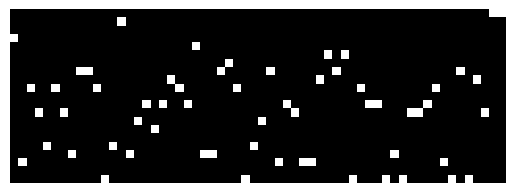

In [74]:
# 显示灰度图
plt.imshow(showData(proteinData[0]), cmap='gray', vmin=-1, vmax=1)  # 设置灰度图的范围为[-1, 1]
plt.axis('off')
plt.show()

In [142]:
def plot(imgs, with_orig=False, row_title=None, **imshow_kwargs):
    if not isinstance(imgs[0], list):
        # Make a 2d grid even if there's just 1 row
        imgs = [[img] for img in imgs]
        
    num_rows = len(imgs)
    num_cols = 1 + with_orig
    fig, axs = plt.subplots(figsize=(200,200), nrows=num_rows, ncols=num_cols, squeeze=False)
    for row_idx, row in enumerate(imgs):
        if with_orig:
            ax = axs[row_idx, 0]
            ax.imshow(showData(np.asarray(row[0]).squeeze()), **imshow_kwargs, cmap='gray', vmin=-1, vmax=1)
            ax.set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])
            ax.set(title='Original image')
            ax.title.set_size(8)
            row = row[1:]
        for col_idx, img in enumerate(row):
            ax = axs[row_idx, col_idx + with_orig]
            ax.imshow(showData(np.asarray(img).squeeze()), **imshow_kwargs, cmap='gray', vmin=-1, vmax=1)
            ax.set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])

    if row_title is not None:
        for row_idx in range(num_rows):
            axs[row_idx, 0].set(ylabel=row_title[row_idx])

    plt.tight_layout()


In [76]:
proteinSample = torch.tensor(proteinData[0], device='cpu')
proteinNoise = get_noisy(proteinSample, torch.tensor([50]))

In [143]:
plot([get_noisy(proteinSample, torch.tensor([t])) for t in [0, 10, 20, 30, 40, 50]])

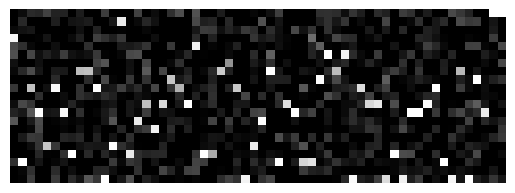

In [86]:
import numpy as np
import matplotlib.pyplot as plt
# 显示灰度图
plt.imshow(showData(proteinNoise.numpy()), cmap='gray', vmin=-1, vmax=1)  # 设置灰度图的范围为[-1, 1]
plt.axis('off')
plt.show()

In [107]:
proteinNoise

tensor([[-1.1843, -0.2633, -1.2648,  ..., -0.8904, -0.8723, -0.6858],
        [-1.0902, -1.0806,  1.0274,  ..., -0.8645, -0.9600, -1.2897],
        [-1.0835, -1.2472, -0.4829,  ..., -0.7044, -0.5575, -0.6760],
        ...,
        [-0.9542, -0.8000, -0.9240,  ..., -0.9110, -1.1583, -0.7543],
        [-0.7530, -0.9393, -0.5043,  ..., -1.1658, -1.1013, -1.1858],
        [-1.0169, -0.9038, -1.0874,  ..., -0.8915, -1.4762, -0.9404]],
       dtype=torch.float64)

In [87]:
x_sample = proteinNoise.to(device).reshape(1, 1, 60, 60).float()

In [106]:
x_sample

tensor([[[[-1.1843, -0.2633, -1.2648,  ..., -0.8904, -0.8723, -0.6858],
          [-1.0902, -1.0806,  1.0274,  ..., -0.8645, -0.9600, -1.2897],
          [-1.0835, -1.2472, -0.4829,  ..., -0.7044, -0.5575, -0.6760],
          ...,
          [-0.9542, -0.8000, -0.9240,  ..., -0.9110, -1.1583, -0.7543],
          [-0.7530, -0.9393, -0.5043,  ..., -1.1658, -1.1013, -1.1858],
          [-1.0169, -0.9038, -1.0874,  ..., -0.8915, -1.4762, -0.9404]]]],
       device='cuda:0')

In [88]:
proteinDenoise = single_sample(model, x_sample, image_size=image_size, batch_size=1, channels=1, t = 50)

sampling loop time step:   0%|          | 0/50 [00:00<?, ?it/s]

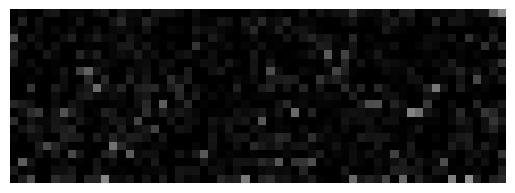

In [89]:
plt.imshow(showData(proteinDenoise[-1].squeeze()), cmap='gray', vmin=-1, vmax=1)  # 设置灰度图的范围为[-1, 1]
plt.axis('off')
plt.show()

In [77]:
np.set_printoptions(threshold=np.inf)

In [111]:
import numpy as np

def normalize_onehot(matrix):
    # 找到每一行最大值的索引
    max_values = np.max(matrix[:,:,:,:21], axis=-1, keepdims=True)
    
    # 初始化一个与输入矩阵相同大小的数组，用于存储转换后的编码
    onehot_matrix = np.where(matrix == max_values, 1, 0)
    
    return onehot_matrix

# 转换为正负 1 编码
onehot_encoding = normalize_onehot(proteinDenoise[-1])
onehot_encoding

array([[[[0, 0, 0, ..., 0, 0, 0],
         [0, 0, 1, ..., 0, 0, 0],
         [1, 0, 0, ..., 0, 0, 0],
         ...,
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0]]]])

In [112]:
denoiseList = []
for i in range(50):
    denoiseList.append(proteinDenoise[i])

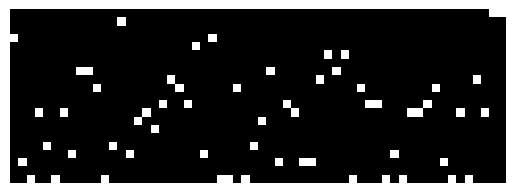

In [113]:
plt.imshow(showData(onehot_encoding[-1].squeeze()), cmap='gray', vmin=0, vmax=1)  # 设置灰度图的范围为[-1, 1]
plt.axis('off')
plt.show()

In [144]:
plot([proteinDenoise[t].squeeze() for t in [0, 10, 20, 30, 40, 49]])

In [ ]:
onehot_encoding

In [50]:
import numpy as np

def decode_onehot(matrix):
    amino_acids = 'ACDEFGHIKLMNPQRSTVWY'
    decoded_sequences = []
    for sample in matrix:
        sequence = ''
        for column in sample[0]:
            index = np.argmax(column)
            if index < len(amino_acids):
                sequence += amino_acids[index]
            else:
                sequence += ''
        decoded_sequences.append(sequence)
    return decoded_sequences

decoded_sequences = decode_onehot(onehot_encoding)
print(decoded_sequences)

['VDAKFAKEQQNAFYEIKHLPNLTEVAANAFIQDLKDDPSQSANLLAEAKKLNDAKAPK']
